In [1]:
import geopandas as gpd #handle shape file 
import matplotlib.pyplot as plt #Make graph

import numpy as np #Mathematical functions
import pandas as pd #

from shapely import wkt
#import geopy.distance
from math import radians, cos, sin, asin, sqrt

from pandas.core.frame import DataFrame
from functools import reduce
import pyproj as pp
from pyproj import Proj


from pylab import rcParams 
rcParams['figure.figsize'] = 15,15

import warnings
warnings.filterwarnings('ignore')

In [22]:
#Parroquias Urbanas de Quito
df_uquito= gpd.read_file('../data/Quito Urbano/Quito_Urbano.shp')

In [82]:
#Database from MIES
#Ubicación de los centros de MIES
df_mies_c= pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2023/ua_coord_validadas_ago2023.xlsx")

df_mies_c.dropna(subset=['x'], inplace = True )

#Reproj
projWGS84 = Proj(init="EPSG:32733",zone=17,ellps='WGS84', preserve_units=False)
df_mies_c[['wgs_x', 'wgs_y']] = df_mies_c.apply(lambda row:projWGS84(row['x'], row['y'], inverse=True), axis=1).apply(pd.Series)

df_MIES_c_gdf= gpd.GeoDataFrame(df_mies_c, geometry= gpd.points_from_xy(df_mies_c['wgs_x'],df_mies_c['wgs_y']))
df_MIES_c_gdf['geometry'] = df_MIES_c_gdf['geometry'].astype(str).apply(wkt.loads)

df_MIES_c_gdf.head()

,zon_plan,dis_sen,uni_des_mi,dpa_desprov,dpa_prov,dpa_descan,dpa_can,dpa_despar,dpa_par,region,...,ext_pob,pob,no_pob,x,y,corte,estado,wgs_x,wgs_y,geometry
0,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,GONZÁLEZ SUÁREZ,40101,Sierra,...,6.0,9.0,10.0,865697.63,10092082.00,ago 2023,NaN,-77.715036,0.831716,POINT (-77.71504 0.83172)
1,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,GONZÁLEZ SUÁREZ,40101,Sierra,...,6.0,20.0,4.0,863141.06,10088504.00,ago 2023,NaN,-77.738002,0.799417,POINT (-77.73800 0.79942)
2,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,GONZÁLEZ SUÁREZ,40101,Sierra,...,9.0,22.0,6.0,866181.69,10092470.00,ago 2023,NaN,-77.710690,0.835217,POINT (-77.71069 0.83522)
3,Zona Planificación: Guayaquil,09D24,UNIDAD DESCONCENTRADA DISTRITAL TIPO B DURAN,GUAYAS,9,DURAN,907,ELOY ALFARO (DURAN),90750,Costa,...,7.0,31.0,17.0,630833.44,9760962.74,ago 2023,NaN,-79.823484,-2.162176,POINT (-79.82348 -2.16218)
4,Zona Planificación: Guayaquil,09D05,UNIDAD DESCONCENTRADA ZONAL 8,GUAYAS,9,GUAYAQUIL,901,TARQUI,90112,Costa,...,1.0,10.0,20.0,611204.98,9765639.33,ago 2023,NaN,-80.000000,-2.120000,POINT (-80.00000 -2.12000)


In [84]:
df_MIES_quito= df_MIES_c_gdf[df_MIES_c_gdf['dpa_descan']=='DISTRITO METROPOLITANO DE QUITO']

In [85]:
df_Centros_MIES = gpd.sjoin(df_MIES_quito,df_uquito,how='left')
df_Centros_MIES.head(3)

,zon_plan,dis_sen,uni_des_mi,dpa_desprov,dpa_prov,dpa_descan,dpa_can,dpa_despar_left,dpa_par,region,...,corte,estado,wgs_x,wgs_y,geometry,index_right,id,dpa_parroq,dpa_despar_right,Urbana
152,Zona Planificación: Quito,17D09,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,PICHINCHA,17,DISTRITO METROPOLITANO DE QUITO,1701,PIFO,170175,Sierra,...,ago 2023,NaN,-78.340432,-0.227926,POINT (-78.34043 -0.22793),NaN,NaN,NaN,NaN,NaN
153,Zona Planificación: Quito,17D09,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,PICHINCHA,17,DISTRITO METROPOLITANO DE QUITO,1701,TUMBACO,170184,Sierra,...,ago 2023,NaN,-78.405094,-0.212745,POINT (-78.40509 -0.21274),NaN,NaN,NaN,NaN,NaN
154,Zona Planificación: Quito,17D09,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,PICHINCHA,17,DISTRITO METROPOLITANO DE QUITO,1701,TUMBACO,170184,Sierra,...,ago 2023,NaN,-78.405094,-0.212745,POINT (-78.40509 -0.21274),NaN,NaN,NaN,NaN,NaN


<Axes: >

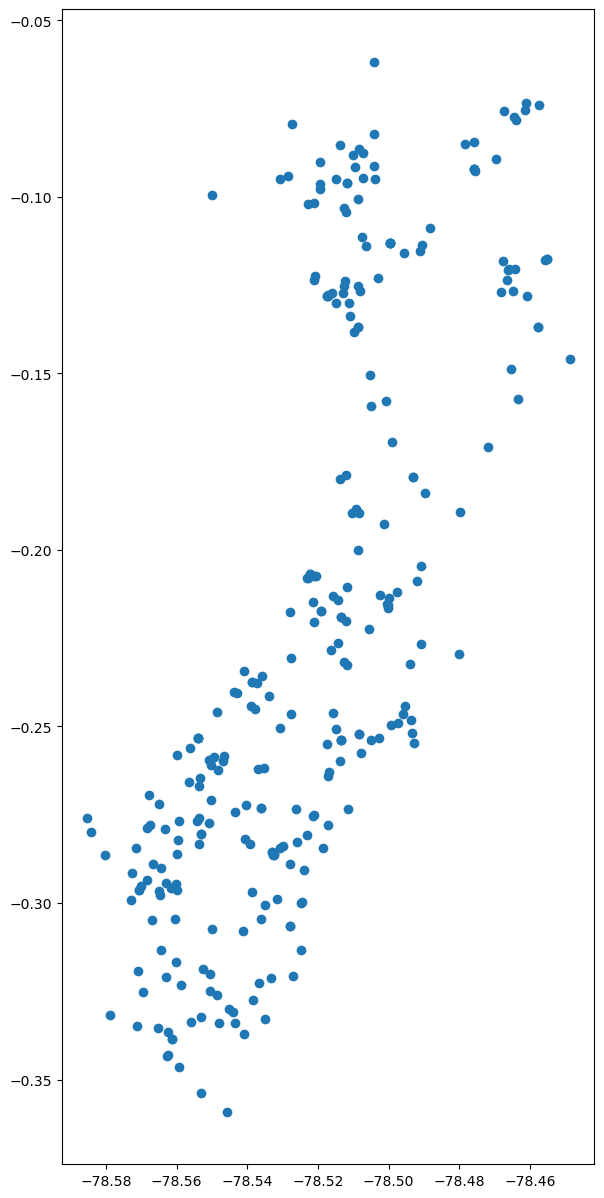

In [86]:
df_Centros_MIES.dropna(subset=['dpa_parroq'], inplace = True )
df_Centros_MIES.plot()

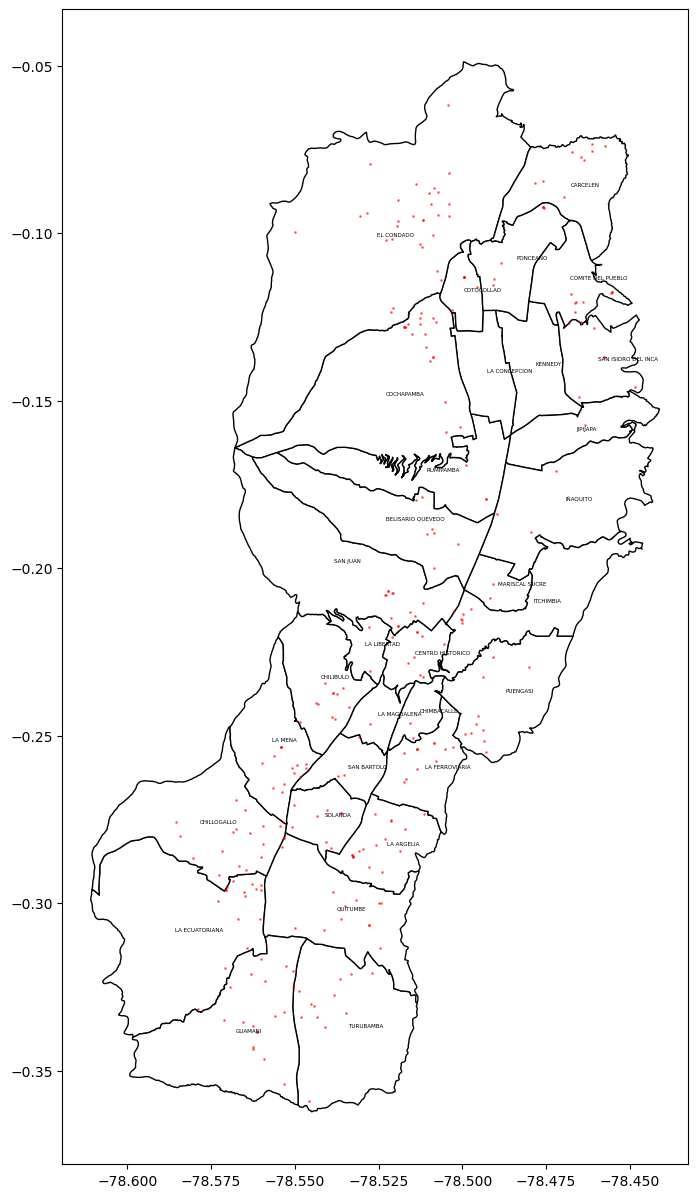

In [87]:
# Crear la figura y los ejes
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Graficar los polígonos del DataFrame df_barr. 
df_uquito.plot(ax=ax, color='white', edgecolor='black')

# Graficar los puntos del DataFrame df_final.
df_Centros_MIES.plot(ax=ax, marker='o', color='red', markersize=1, alpha=0.5)

# Agregar etiquetas a las zonas de df_barr
for x, y, label in zip(df_uquito.geometry.centroid.x, df_uquito.geometry.centroid.y, df_uquito['dpa_despar']):
    ax.annotate(label, (x, y), fontsize=4)

plt.show()

In [88]:
df_MIES= gpd.read_file('../data/MIES points/MIES_points.shp')

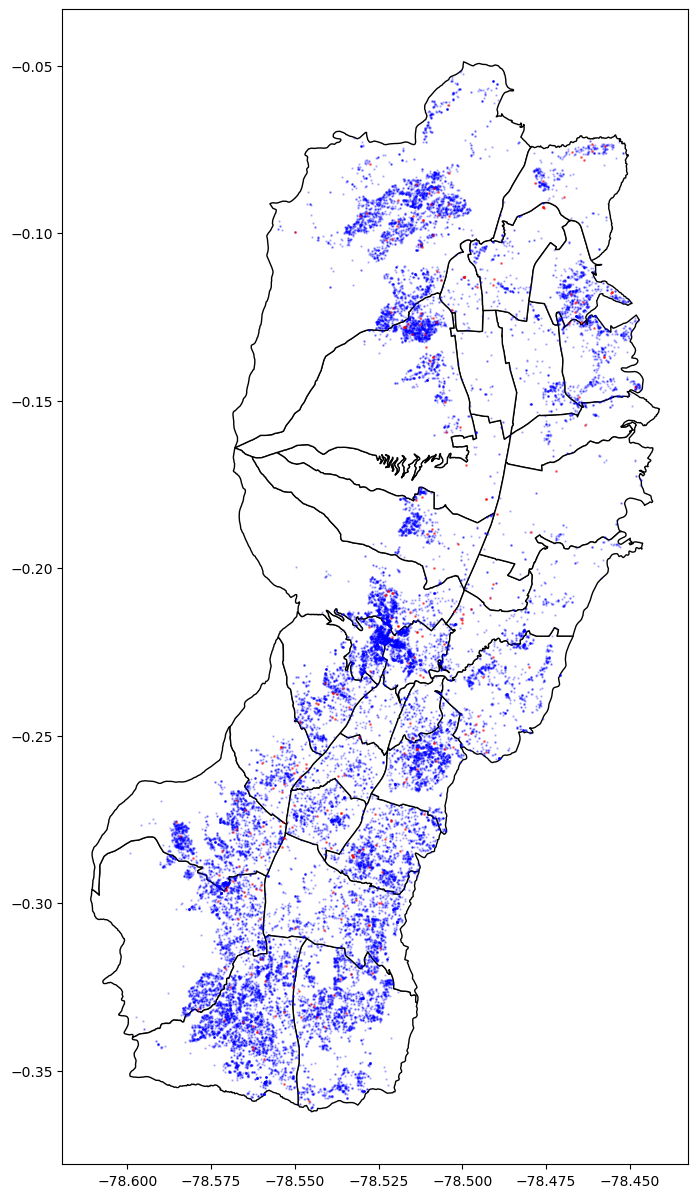

In [91]:


fig, ax = plt.subplots()

ax.set_aspect('equal')

df_uquito.plot(ax=ax, color='white', edgecolor='black')
df_MIES.plot(ax=ax, marker='o', color='blue', markersize=0.5, alpha=0.25)
df_Centros_MIES.plot(ax=ax, marker='o', color='red', markersize=1, alpha=0.5)
plt.show()


In [ ]:
df_uquito
df_MIES
df_Centros_MIES
gdf = gdf.set_crs(4326, allow_override=True)

In [119]:
df_Centros_MIES2=df_Centros_MIES.set_crs(32717, allow_override=True) 

In [120]:
df_MIES2=df_MIES.set_crs(32717, allow_override=True) 

In [121]:
df_MIES2.crs

<Projected CRS: EPSG:32717>
Name: WGS 84 / UTM zone 17S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, southern hemisphere between 80°S and equator, onshore and offshore. Ecuador. Peru.
- bounds: (-84.0, -80.0, -78.0, 0.0)
Coordinate Operation:
- name: UTM zone 17S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [122]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia en kilómetros entre dos puntos definidos por sus coordenadas
    latitud y longitud utilizando la fórmula del haversine.
    """
    # Radio de la Tierra en kilómetros
    R = 6371.0

    # Convertir coordenadas de grados a radianes
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Diferencia de latitud y longitud
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Aplicar la fórmula del haversine
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distancia = R * c

    return distancia

# Calcular la distancia en kilómetros entre los puntos de hogares y los centros
distancias_km = []
for hogar in df_MIES2.itertuples():
    min_dist_km = float('inf')
    for centro in df_Centros_MIES2.itertuples():
        dist_km = haversine(hogar.geometry.y, hogar.geometry.x, centro.geometry.y, centro.geometry.x)
        if dist_km < min_dist_km:
            min_dist_km = dist_km
    distancias_km.append(min_dist_km)

# Agregar la distancia en kilómetros a los puntos de hogares
df_MIES2["distancia_km"] = distancias_km



In [126]:
df_MIES2.distancia_km.mean()

0.42174793358657986

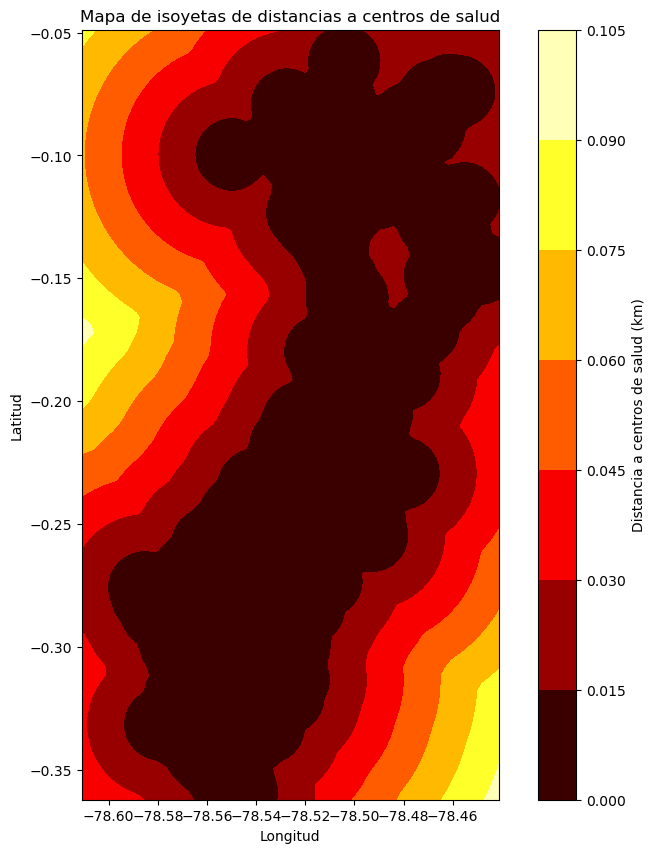

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Crear una cuadrícula regular para el área de interés
x_min, y_min, x_max, y_max = df_uquito.total_bounds  # Obtener los límites de la región
resolucion = 100  # Resolución de la cuadrícula
x = np.linspace(x_min, x_max, resolucion)
y = np.linspace(y_min, y_max, resolucion)
X, Y = np.meshgrid(x, y)

# Calcular las distancias desde cada punto de la cuadrícula hasta los centros de salud más cercanos
distancias_grilla = np.empty_like(X)
for i in range(resolucion):
    for j in range(resolucion):
        min_dist = float('inf')
        for centro in df_Centros_MIES2.geometry:
            dist = np.sqrt((X[i, j] - centro.x)**2 + (Y[i, j] - centro.y)**2)
            if dist < min_dist:
                min_dist = dist
        distancias_grilla[i, j] = min_dist

# Graficar el mapa de isoyetas
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, distancias_grilla, cmap='hot')
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud')
plt.gca().set_aspect('equal', adjustable='box')

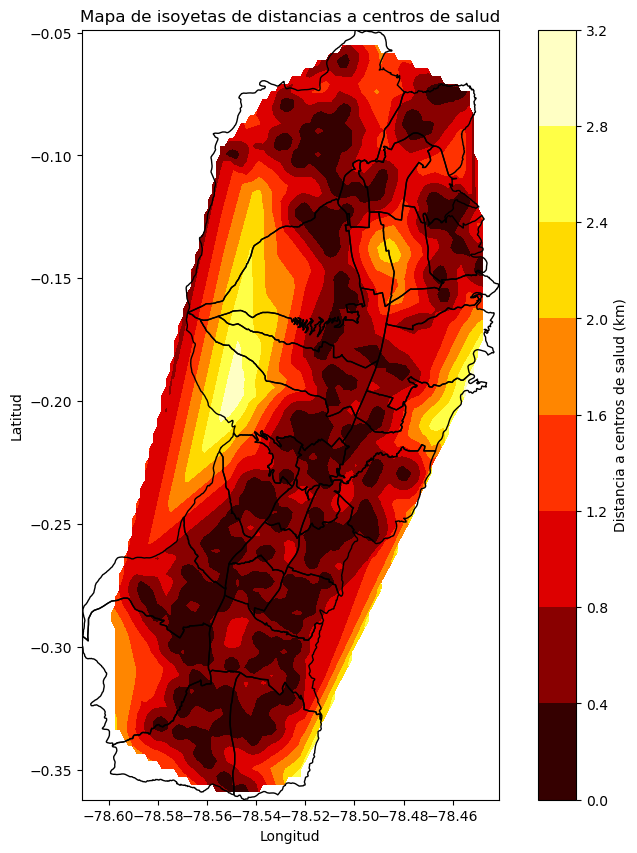

In [133]:
from scipy.interpolate import griddata

# Crear una cuadrícula regular para el área de interés
x_min, y_min, x_max, y_max = df_uquito.total_bounds  # Obtener los límites de la región
resolucion = 100  # Resolución de la cuadrícula
x = np.linspace(x_min, x_max, resolucion)
y = np.linspace(y_min, y_max, resolucion)
X, Y = np.meshgrid(x, y)

# Interpolar las distancias desde los puntos de hogares a la cuadrícula regular
distancias_interpoladas = griddata((df_MIES2.geometry.x, df_MIES2.geometry.y), distancias_km, (X, Y), method='linear')

# Graficar el mapa de isoyetas
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, distancias_interpoladas, cmap='hot')
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud')
plt.gca().set_aspect('equal', adjustable='box')

# Graficar los polígonos sobre el mapa de isoyetas
df_uquito.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

plt.show()


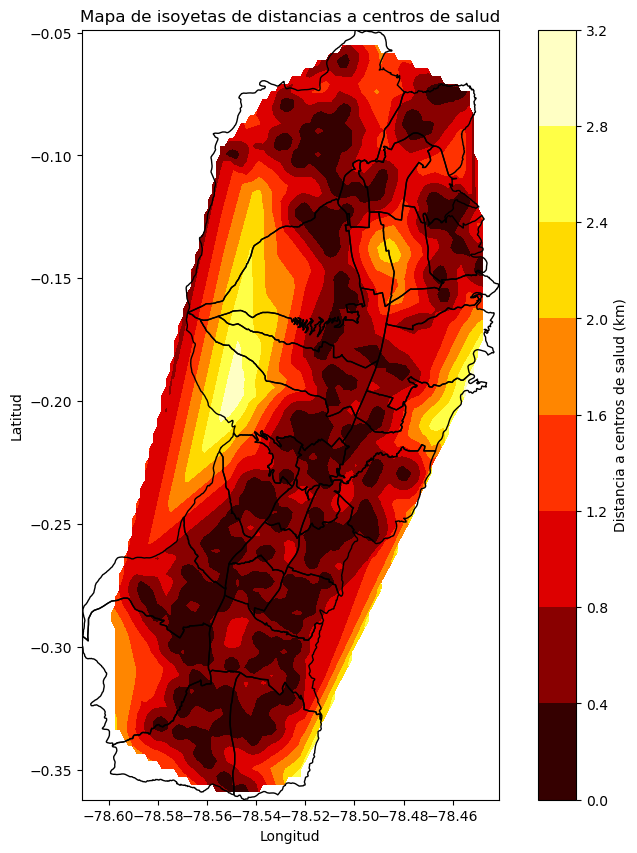

In [135]:
from scipy.interpolate import griddata

# Obtener los límites de los polígonos
x_min, y_min, x_max, y_max = df_uquito.total_bounds

# Crear una cuadrícula que se ajuste a los límites de los polígonos
x = np.linspace(x_min, x_max, resolucion)
y = np.linspace(y_min, y_max, resolucion)
X, Y = np.meshgrid(x, y)

# Interpolar las distancias desde los puntos de hogares a la cuadrícula regular
distancias_interpoladas = griddata((df_MIES2.geometry.x, df_MIES2.geometry.y), distancias_km, (X, Y), method='linear')

# Graficar el mapa de isoyetas
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, distancias_interpoladas, cmap='hot')
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud')
plt.gca().set_aspect('equal', adjustable='box')

# Graficar los polígonos sobre el mapa de isoyetas
df_uquito.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

plt.show()


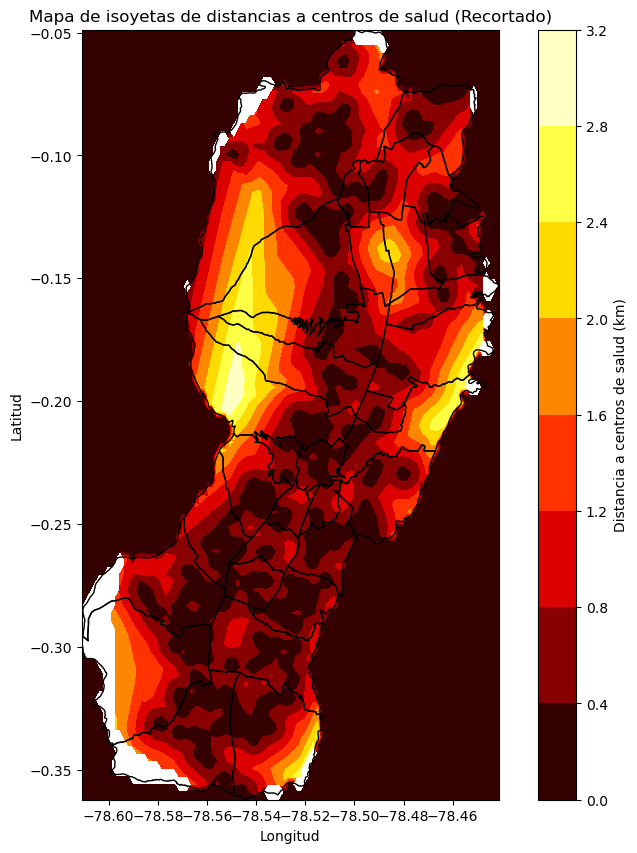

In [137]:
from matplotlib.path import Path

# Crear una lista para almacenar las máscaras de recorte de cada polígono de barrios
barrios_masks = []

# Iterar sobre los polígonos de los barrios y crear una máscara de recorte para cada uno
for polygon in df_uquito.geometry:
    barrios_masks.append(Path(polygon.exterior.coords))

# Crear una matriz para almacenar las isoyetas recortadas para cada polígono de barrios
isoyetas_recortadas = np.zeros_like(distancias_interpoladas)

# Recorrer todas las máscaras de recorte y recortar las isoyetas
for mask in barrios_masks:
    isoyetas_recortadas = np.where(mask.contains_points(np.vstack((X.flatten(), Y.flatten())).T).reshape(X.shape), distancias_interpoladas, isoyetas_recortadas)

# Graficar el mapa de isoyetas recortadas
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, isoyetas_recortadas, cmap='hot')
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud (Recortado)')
plt.gca().set_aspect('equal', adjustable='box')

# Graficar los polígonos sobre el mapa de isoyetas recortadas
df_uquito.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

plt.show()


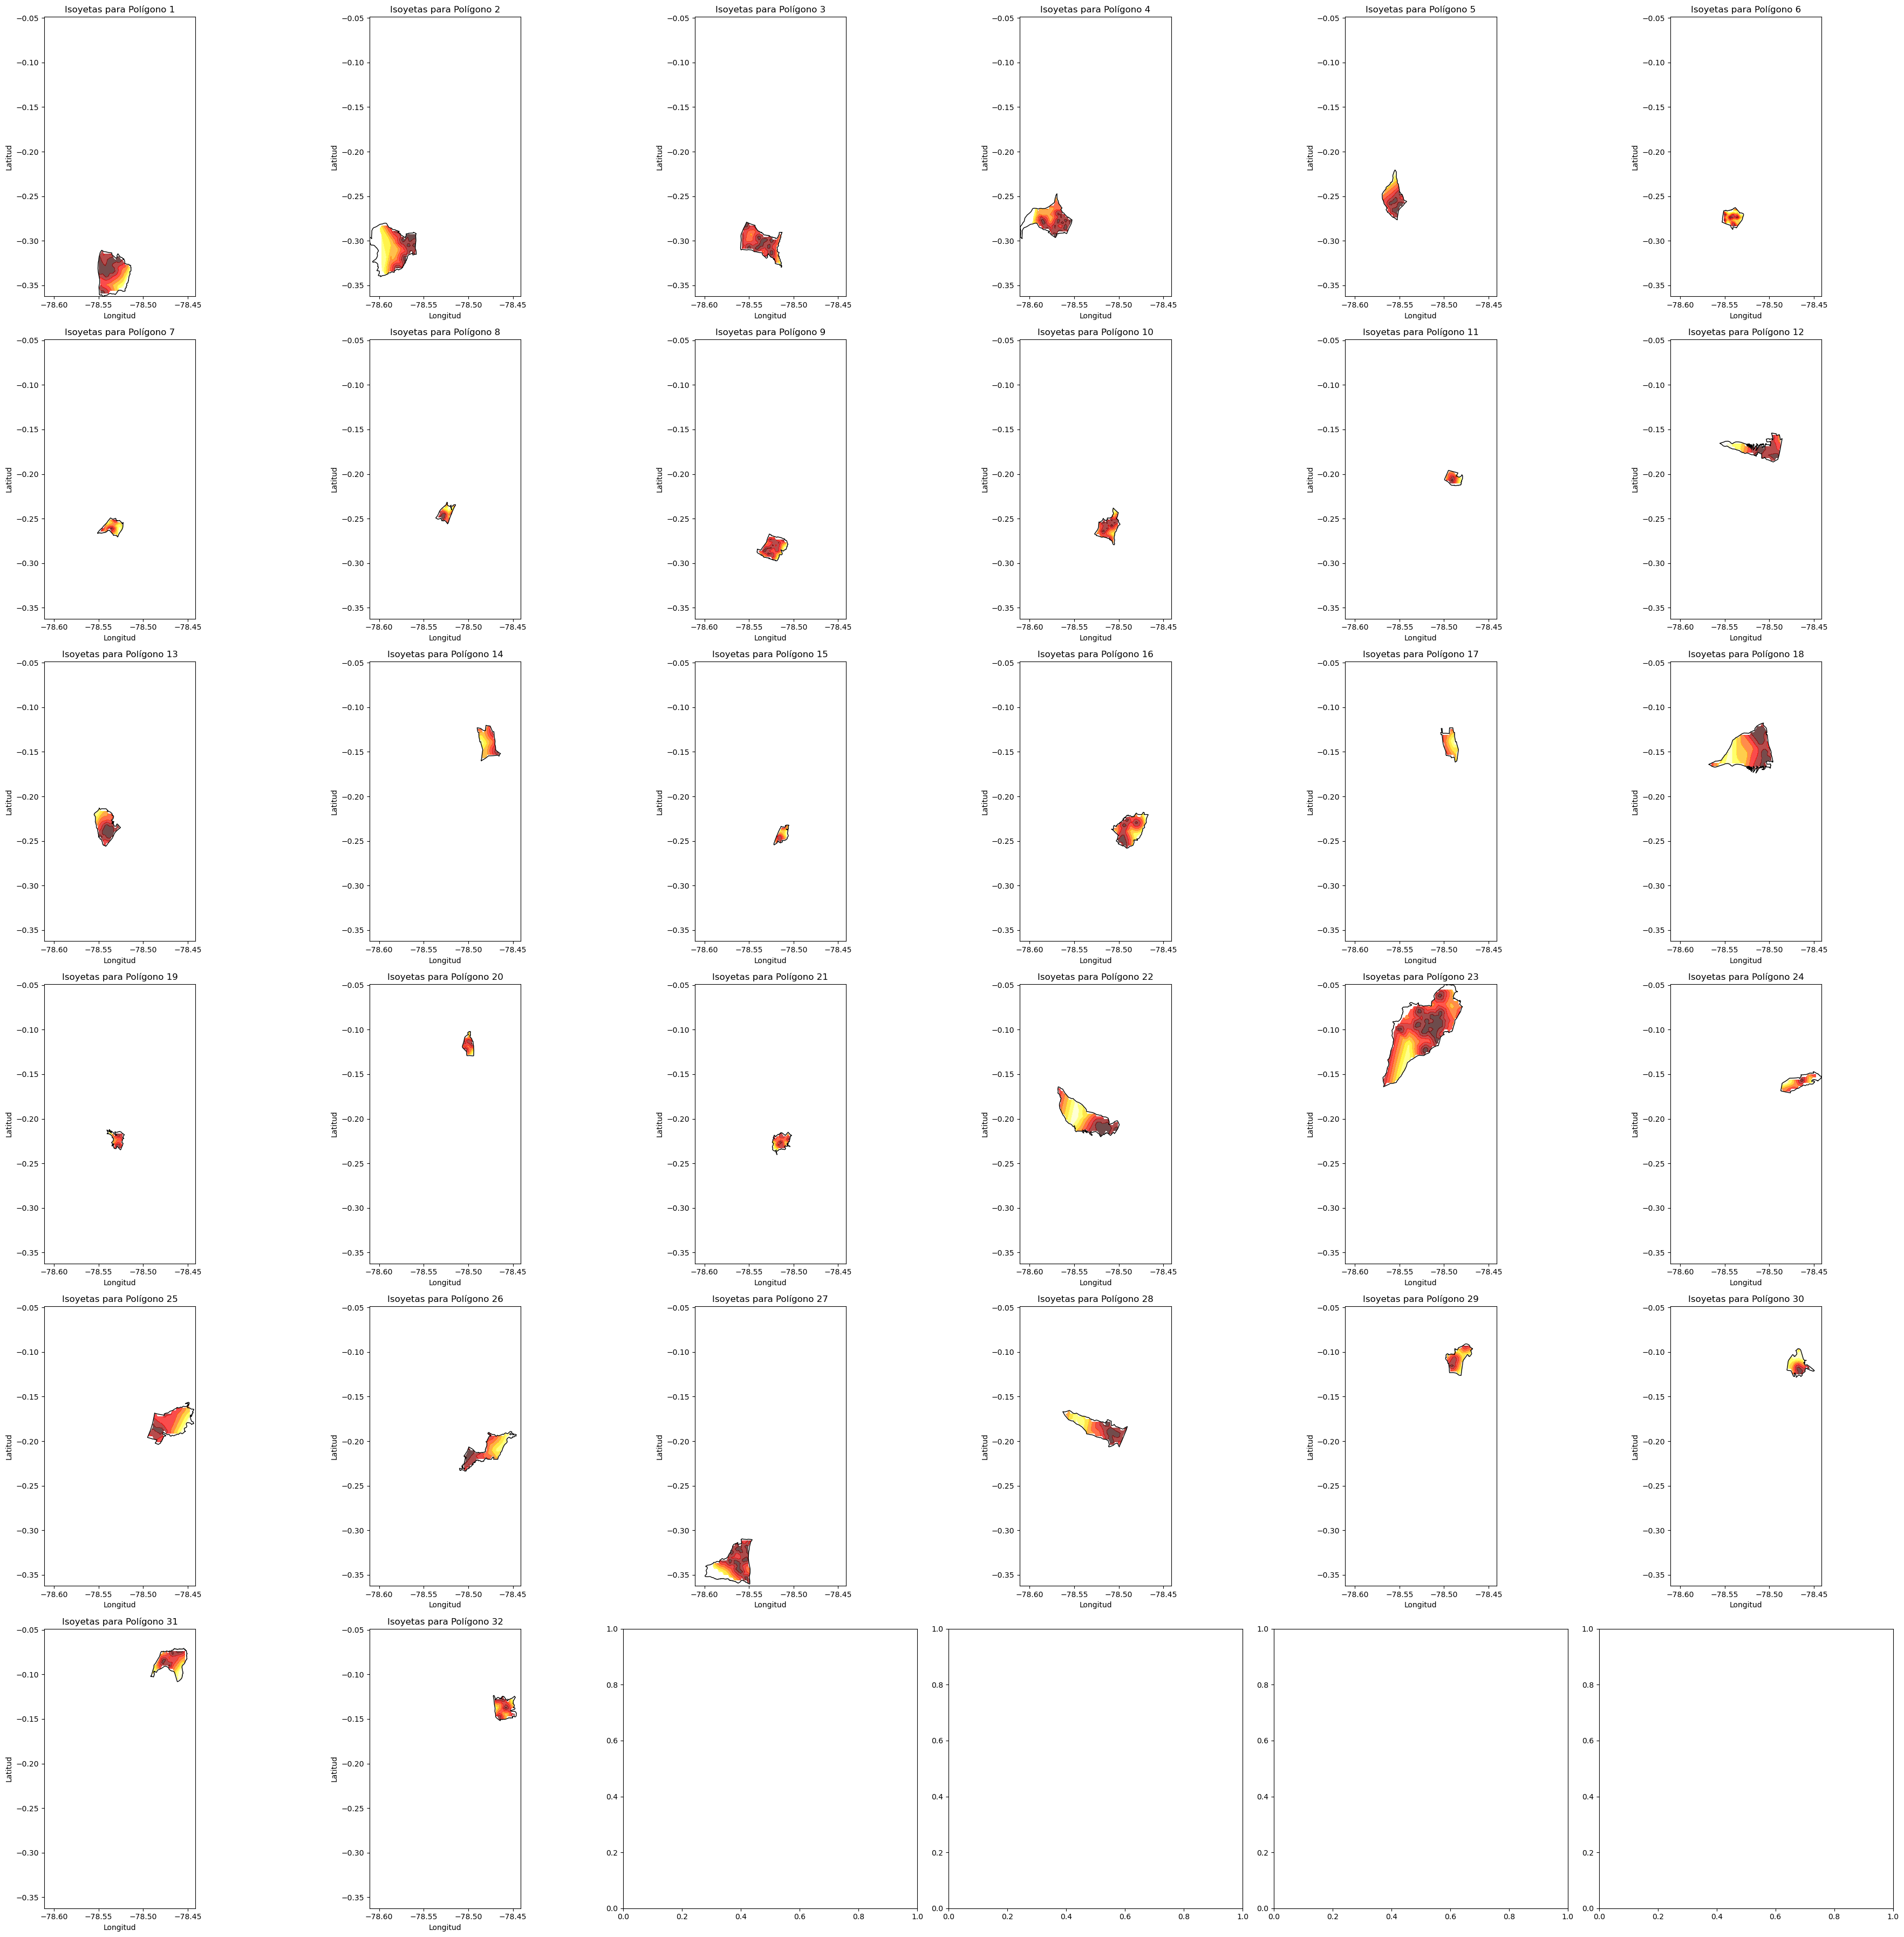

In [139]:
from matplotlib.path import Path

# Crear una lista para almacenar las máscaras de recorte de cada polígono de barrios
barrios_masks = []

# Iterar sobre los polígonos de los barrios y crear una máscara de recorte para cada uno
for polygon in df_uquito.geometry:
    barrios_masks.append(Path(polygon.exterior.coords))

# Crear una figura con una cuadrícula de subtramas para cada polígono de barrios
num_plots = len(barrios_masks)
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))

# Iterar sobre cada polígono de barrios y calcular y graficar las isoyetas recortadas
for i, (mask, ax) in enumerate(zip(barrios_masks, axes.flat)):
    isoyetas_recortadas = np.where(mask.contains_points(np.vstack((X.flatten(), Y.flatten())).T).reshape(X.shape), distancias_interpoladas, np.nan)
    ax.contourf(X, Y, isoyetas_recortadas, cmap='hot', alpha=0.7)
    ax.set_title(f'Isoyetas para Polígono {i + 1}')
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    ax.set_aspect('equal', adjustable='box')
    df_uquito.iloc[i:i+1].plot(ax=ax, facecolor='none', edgecolor='black')

# Ajustar la disposición de los subtramas y mostrar la figura
plt.tight_layout()
plt.show()


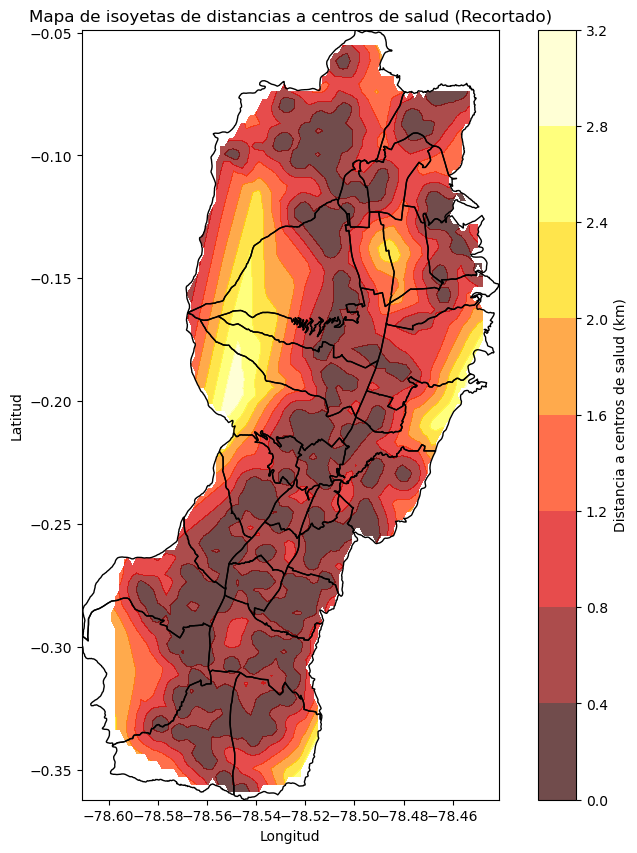

In [142]:
from matplotlib.path import Path

# Crear una máscara compuesta de todos los polígonos de los barrios
barrios_mask = np.zeros_like(X, dtype=bool)
for polygon in df_uquito.geometry:
    barrios_mask |= Path(polygon.exterior.coords).contains_points(np.vstack((X.flatten(), Y.flatten())).T).reshape(X.shape)

# Crear las isoyetas recortadas usando la máscara de los barrios
isoyetas_recortadas = np.where(barrios_mask, distancias_interpoladas, np.nan)

# Graficar el mapa de isoyetas recortadas
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, isoyetas_recortadas, cmap='hot', alpha=0.7)
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud (Recortado)')

# Graficar los polígonos sobre el mapa de isoyetas recortadas
df_uquito.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

plt.show()



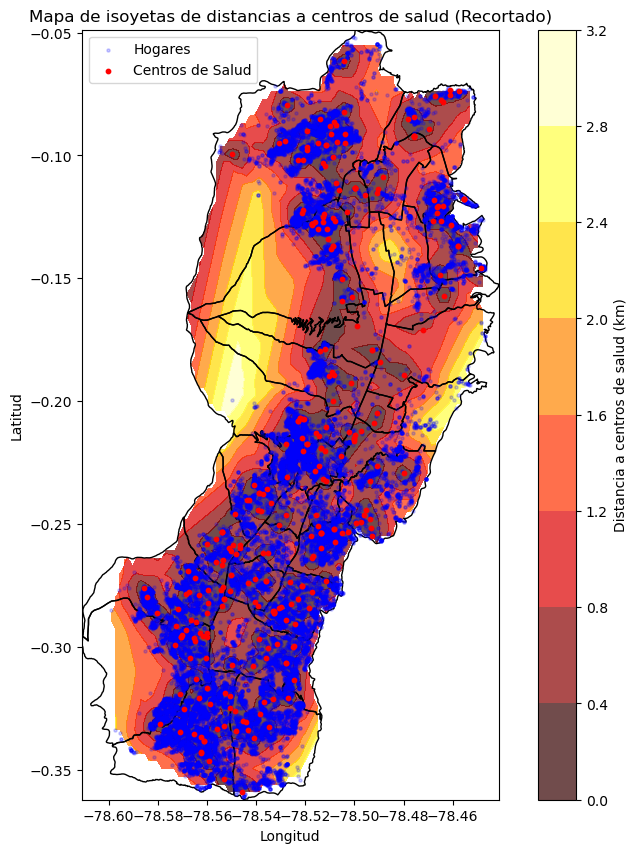

In [146]:
from matplotlib.path import Path

# Crear una máscara compuesta de todos los polígonos de los barrios
barrios_mask = np.zeros_like(X, dtype=bool)
for polygon in df_uquito.geometry:
    barrios_mask |= Path(polygon.exterior.coords).contains_points(np.vstack((X.flatten(), Y.flatten())).T).reshape(X.shape)

# Crear las isoyetas recortadas usando la máscara de los barrios
isoyetas_recortadas = np.where(barrios_mask, distancias_interpoladas, np.nan)

# Graficar el mapa de isoyetas recortadas
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, isoyetas_recortadas, cmap='hot', alpha=0.7)
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud (Recortado)')

# Graficar los polígonos de los barrios
df_uquito.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

# Graficar los puntos de hogares y centros de salud
df_MIES2.plot(ax=plt.gca(), color='blue', markersize=5, label='Hogares',alpha=0.2)
df_Centros_MIES2.plot(ax=plt.gca(), color='red', markersize=10, label='Centros de Salud')

plt.legend()

plt.show()


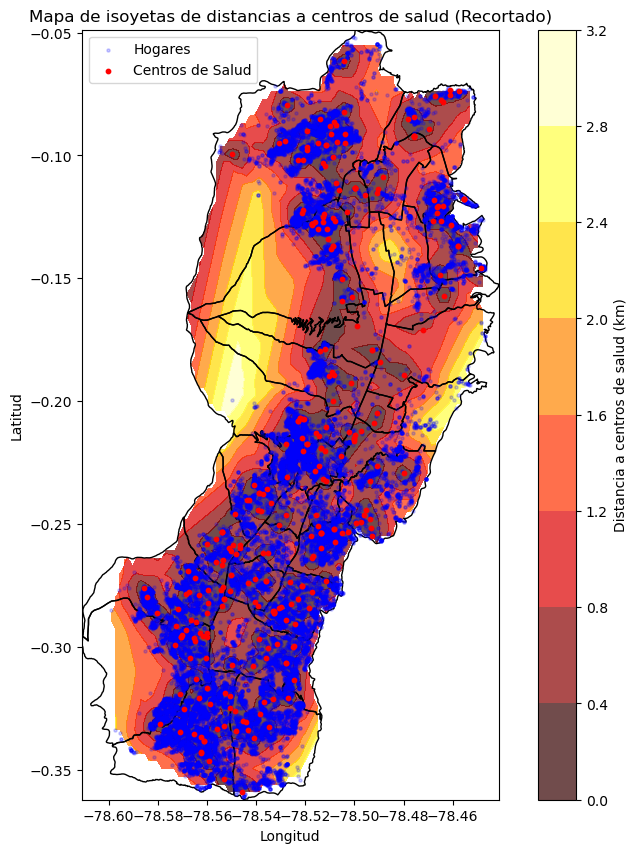

In [148]:
barrios_mask = np.zeros_like(X, dtype=bool)
for polygon in df_uquito.geometry:
    barrios_mask |= Path(polygon.exterior.coords).contains_points(np.vstack((X.flatten(), Y.flatten())).T).reshape(X.shape)

# Crear las isoyetas recortadas usando la máscara de los barrios
isoyetas_recortadas = np.where(barrios_mask, distancias_interpoladas, np.nan)

# Graficar el mapa de isoyetas recortadas
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, isoyetas_recortadas, cmap='hot', alpha=0.7)
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud (Recortado)')

# Graficar los polígonos de los barrios
df_uquito.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

# Graficar los puntos de hogares y centros de salud
df_MIES2.plot(ax=plt.gca(), color='blue', markersize=5, label='Hogares',alpha=0.2)
df_Centros_MIES2.plot(ax=plt.gca(), color='red', markersize=10, label='Centros de Salud')


plt.legend()

plt.show()

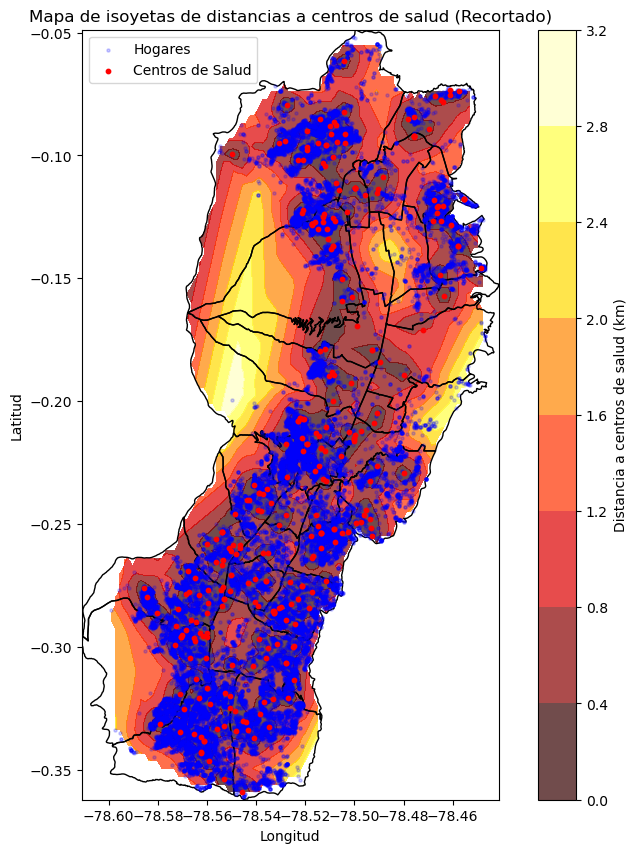

In [149]:
from matplotlib.path import Path

# Crear una máscara compuesta de todos los polígonos de los barrios
barrios_mask = np.zeros_like(X, dtype=bool)
for polygon in df_uquito.geometry:
    barrios_mask |= Path(polygon.exterior.coords).contains_points(np.vstack((X.flatten(), Y.flatten())).T).reshape(X.shape)

# Crear las isoyetas recortadas usando la máscara de los barrios
isoyetas_recortadas = np.where(barrios_mask, distancias_interpoladas, np.nan)

# Enmascarar las áreas donde no hay puntos de hogares ni centros de salud
isoyetas_recortadas[~np.isfinite(isoyetas_recortadas)] = np.nan

# Graficar el mapa de isoyetas recortadas
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, isoyetas_recortadas, cmap='hot', alpha=0.7)
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud (Recortado)')

# Graficar los polígonos de los barrios
df_uquito.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

# Graficar los puntos de hogares y centros de salud
df_MIES2.plot(ax=plt.gca(), color='blue', markersize=5, label='Hogares',alpha=0.2)
df_Centros_MIES2.plot(ax=plt.gca(), color='red', markersize=10, label='Centros de Salud')

plt.legend()

plt.show()


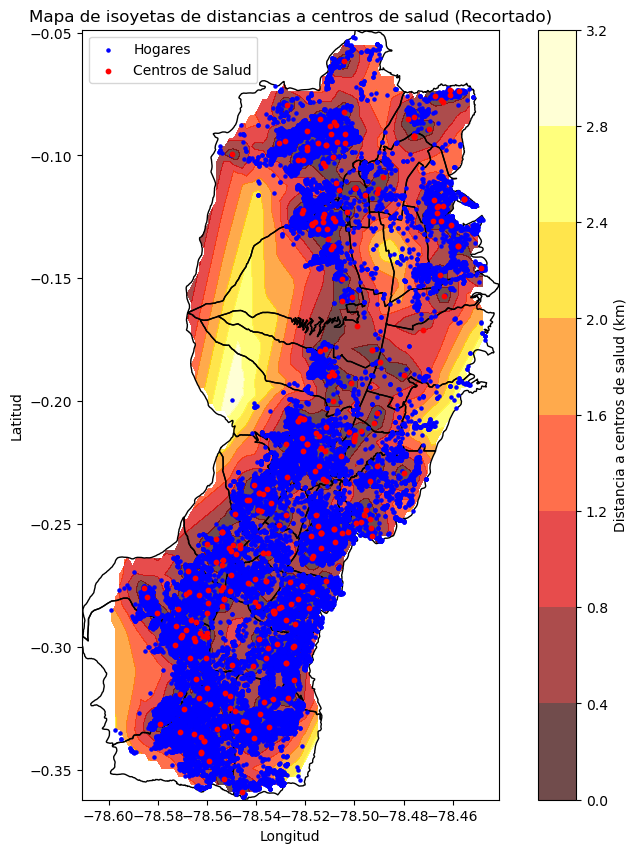

In [151]:
from matplotlib.path import Path

# Crear una máscara compuesta de todos los polígonos de los barrios
barrios_mask = np.zeros_like(X, dtype=bool)
for polygon in df_uquito.geometry:
    barrios_mask |= Path(polygon.exterior.coords).contains_points(np.vstack((X.flatten(), Y.flatten())).T).reshape(X.shape)

# Crear las isoyetas recortadas usando la máscara de los barrios
isoyetas_recortadas = np.where(barrios_mask, distancias_interpoladas, np.nan)

# Crear una máscara para las áreas donde no hay puntos de hogares ni centros de salud
mask_no_data = np.isnan(isoyetas_recortadas)

# Graficar el mapa de isoyetas recortadas
plt.figure(figsize=(10, 10))

# Aplicar la máscara para las áreas sin datos al mapa de isoyetas
plt.contourf(X, Y, np.ma.masked_array(isoyetas_recortadas, mask=mask_no_data), cmap='hot', alpha=0.7)
plt.colorbar(label='Distancia a centros de salud (km)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa de isoyetas de distancias a centros de salud (Recortado)')

# Graficar los polígonos de los barrios
df_uquito.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

# Graficar los puntos de hogares y centros de salud
df_MIES2.plot(ax=plt.gca(), color='blue', markersize=5, label='Hogares')
df_Centros_MIES2.plot(ax=plt.gca(), color='red', markersize=10, label='Centros de Salud')

plt.legend()

plt.show()
